# 2CSSID-TP07. Régularisation et sélection d'attributs

Dans ce TP, nous allons voir l'effet de la régularisation et la sélaction d'attributs sur l'apprentissage.
Premierement, nous allons implémenter les deux fonctions de réglage L1 et L2, ainsi que la méthode de filtrage ANOVA.
Ensuite, nous allons tester l'effet de ces techniques sur la performance en utilisant plusieurs métriques.

Binômes : 
- **Binôme 1 :Bendaho Sarra** 
- **Binôme 2 :Chenni Nidhal Eddine**

In [1]:
import matplotlib
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
from matplotlib      import colors 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.20.1', '1.2.4', '3.3.4')

In [2]:
from typing import Tuple, List, Dict, Callable

## I. Réalisation des algorithmes

Dans cette partie, nous allons implémenter deux fonctions de régularisation et une fonction de filtrage. 
La régularisation sera appliquée sur la régression logistique binaire dont le code est fourni ici.

In [3]:
# Le code de la réression logistique 
# Ne modifier pas ceci

# Somme pondérée des caractéristiques
def zf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return np.dot(X, theta)

# Transformation d'une valeur à une probabilité
def sg(Z: np.ndarray) -> np.ndarray:
    return  1 / (1 + np.exp(-Z))

# probabilité d'un échantillons
def hf(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return sg(zf(X, theta))

# Fonction objective
# utilisation d'un petit nombre pour éviter log(0)
def BCE(Y: np.ndarray, H: np.ndarray, e: float=1e-8) -> float: 
    return - np.mean(Y * np.log(H) + (1-Y) * np.log(1-H))  

# Fonction des gradients
def dBCE(X: np.ndarray, Y: np.ndarray, H: np.ndarray) -> np.ndarray:
    return  np.dot(X.T, H-Y)/X.shape[0]

# Fonction de mise à jour des paramètres
def majTheta(Theta: np.ndarray, Gradient: np.ndarray, alpha: np.ndarray) -> np.ndarray: 
    return Theta - alpha * Gradient


def normaliser(X: np.ndarray, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray: 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std  = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std

def preparer(X: np.ndarray, norm: np.ndarray=True, 
             const: np.ndarray=True, mean: np.ndarray=None, std: np.ndarray=None) -> np.ndarray: 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre,mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

def generer_zeros_1(nbr: int) -> np.ndarray:
    return np.zeros(nbr)

def generer_uns_1(nbr: int) -> np.ndarray:
    return np.ones(nbr)

### I.1.  Régularisation L2 (Ridge)


#### I.2.1. Fonction du coût de la régularisation L2

La fonction du coût de la régularisation **L2** est calculée somme : 

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques


**Remarque** Dans les énoncés, la régularisation n'est pas divisée par le nombre des échantillons $M$. Mais, en pratique, on la divise. [Voici des réponses sur stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) expliquant pourquoi.

In [4]:
# TODO: Coût L2
def J_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return ( Lambda/(2* M )*np.sum(Theta[1:]**2))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.0005050000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(0.0, 0.0005050000000000001)

#### 1.2.2. Gradients de la régularisation L2

La fonction des gradients de la régularisation **L2** est définie comme suit :
 
$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ si } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **X** : matrice (échantillons X caractéristiques)
- **Y** : vecteur des sorties réelles (échantillons)
- **H** : vecteur des estimations (échantillons)
- **M** : nombre des échantillons


In [5]:
# TODO: Gradient L2
def dJ_L2(Theta: np.ndarray, M: int, Lambda: float=0.) -> np.ndarray:
    res=Lambda/M*Theta
    res[0]=0.
    return res


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  Régularisation L1 (Lasso)

#### I.2.1. Fonction du coût de la régularisation L1

La fonction du coût de la régularisation **L1** sur cette fonction, on aura : 

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques

In [6]:
# TODO: Coût L1
def J_L1(Theta: np.ndarray, M: int, Lambda: float=0.) -> float:
    return Lambda/M*np.sum(np.abs(Theta[1:]))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.011000000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais
J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(0.0, 0.011000000000000001)

#### I.2.2. Mise à jour des paramètres 

La dérivée de $L1$ est :
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

Il est clair que le gradient n'est pas définit dans le cas $\theta_j = 0$. 
En appliquant [le sous-différentiel](https://fr.wikipedia.org/wiki/Sous-diff%C3%A9rentiel), nous aurons : 
$$
\frac{\partial L1}{\partial \theta_j} = 
\begin{cases}
-\frac{\lambda}{M} & \text{si } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{si } \theta_j > 0 \\
\end{cases}
$$

Nous ne pouvons pas utiliser la descente du gradient pour résoudre ça. 
Nous allons utiliser un algorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**. 
$$prox(\theta) = S_{\lambda}(\theta) = 
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite : 
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [7]:
# TODO: Soft-thresholding : prox(theta)
def S(Theta: np.ndarray, Lambda: float) -> np.ndarray: 
    o = Theta
    for i in range(1,len(Theta)) :
        if (Theta[i]<-Lambda) : 
            o[i] = Theta[i]+Lambda
        else :
            if (Theta[i]>Lambda) : 
                o[i] = Theta[i]-Lambda
            else : 
                o[i] = 0.0
    return o

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : array([ 0.5 , -0.15,  0.  ])
#---------------------------------------------------------------------

                     
Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.  ])

### I.3. Régression avec réglularisation

**Rien à programmer ici**


In [8]:
def descente(X: np.ndarray, Y: np.ndarray, Theta: np.ndarray, approx: Callable=None, it_max: int=100, alpha: float=0.1, Lambda: float=0.): 

    M = len(Y)
    
    if approx :
        def maj(Theta, J, dJ):
            J    += J_L1(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba doit être divisé sur le nombre des échantillons
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J    += J_L2(Theta, M, Lambda=Lambda)
            dJ   += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            return J, Theta
            
    couts  = []
    Thetas = []
    
    #pour ne pas modifier le contenu de Theta en entrée
    Theta  = Theta.copy()
    
    # ici, on boucle jusqu'à arriver aux maximum des itérations
    for it in range(it_max):
        H        = hf(X, Theta)
        J        = BCE(Y, H)
        dJ       = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        couts.append(J)
        Thetas.append(Theta.copy())
    
    return Thetas, couts

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([ 0.94839532, -0.56840255,  1.2813832 ]),
#  array([ 0.46328109, -0.15750488,  0.        ]),
#  array([ 0.93431089, -0.53451115,  1.03711393]))
#
#---------------------------------------------------------------------

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])
Y_t     = np.array([1, 0, 1, 0])

# pas de régularisation : Lambda = 0
Theta_P, J_P = descente(X_t, Y_t, Theta_t)
# régularisation L1 : approximation avec lambda
Theta_1, J_1 = descente(X_t, Y_t, Theta_t, approx=S, Lambda=0.1)
# régularisation L2 : lambda sans approximation
Theta_2, J_2 = descente(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]


(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46328109, -0.15750488,  0.        ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [9]:
class RegLogReg(object): # Régression logistique régularisée
    
    # par défaut : pas de régularisation
    def __init__(self, nbr_iter: int=100, 
                 alpha: float=.01, Lambda: float=1.0, norm: bool=True, const: bool=True, reg: str=None): 
        self.nbr_iter = nbr_iter
        self.alpha    = alpha
        self.norm     = norm
        self.const    = const
        self.approx   = None
        self.Lambda   = Lambda
        if reg == "l1":
            self.approx = S
        elif reg != "l2":
            self.Lambda = 0.
    
    def entrainer(self, X: np.ndarray, Y: np.ndarray): 
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const)
        Theta = generer_uns_1(X_pre.shape[1])#
        self.Thetas, self.couts = descente(X_pre, Y, Theta, 
                                          approx=self.approx, 
                                          it_max=self.nbr_iter, 
                                          alpha =self.alpha, 
                                          Lambda=self.Lambda)
        
    # La prédiction
    # si classes=True elle rend une vecteur de 1 et 0
    # sinon elle rend un vecteur de probabilités
    def predire(self, X: np.ndarray, classes: bool=True, seuil: float=0.5, it: int=-1) -> np.ndarray:
        X_pre, self.mean, self.std = preparer(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if classes:
            return (H >= seuil).astype(int)
        return H

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# pas de régularisation
reglog = RegLogReg()
reglog.entrainer(X_t, Y_t)
# régularisation L1
reglog1 = RegLogReg(reg="l1")
reglog1.entrainer(X_t, Y_t)
# régularisation L2
reglog2 = RegLogReg(reg="l2")
reglog2.entrainer(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predire(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([0.79241836, 0.        , 0.        ]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtrage des attributs (ANOVA : Analysis of Variance)

Le nombre des échantillons pour chaque classe est différent. 
Pour cette raison, nous allons implémenter ANOVA for a CRD (COMPLETELY RANDOM DESIGN). 
L'algorithme est expliqué dans [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf). 
Pour valider l'implémentation, nous allons utiliser les mêmes données de la page 10.

#### I.4.1. One way F value pour un seul attribue

Pour un attribut donné ($A$), l'ensemble des valeurs des échantillons sera divisé sur $N$ ensembles, où $N$ est le nombre des classes. 

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Où $\sum_{ij} A_{ij}$ est la somme de toutes les valeurs de toutes les classes, 
$\sum_j |A_j|$ est le nombre total des échantillons (de toutes les classes)

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Où $\sum_{ij} A_{ij}^2$ est les somme des carrées de toutes les valeurs

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Où $\sum_{i} A_{ij}$ est la somme des valeurs de la classe $j$ et $|A_j|$ est le nombre des éléments dans la classe $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [10]:
# TODO: One-way ANOVA pour un attribut
def f_oneway(A: np.ndarray) -> float: 
    # A est une liste de N listes où N est le nombre des classes
    # Ces listes n'ont pas la même taille
    nbrs         = np.array([len(a) for a in A]) # nombre des échantillons de chaque classe
    sommes       = np.array([np.sum(a) for a in A]) # somme des valeurs de chaque classe
    sommes_caree = np.sum([np.sum(np.array(a)**2) for a in A]) # somme des valeurs carrées de toutes les valeurs
    
    # Compléter ici
    #====================================
    CF          = np.sum(sommes)**2/np.sum(nbrs)
    TotalSS     = sommes_caree - CF
    TreatmentSS = np.sum(sommes**2/nbrs)-CF
    ErrorSS     = TotalSS-TreatmentSS
    #====================================
    
    MSB = TreatmentSS / (len(A) - 1) 
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 6.418894830659841 (voir page 11 step 6)
#---------------------------------------------------------------------

AA = [[2., 2.2, 1.8, 2.3, 1.7], [1.7, 1.9, 1.5], [2., 2.4, 2.7, 2.5, 2.4], [2.1, 2.2, 2.2, 1.9]]

f_oneway(AA)

6.418894830659841

#### I.4.2. One way F value pour tous les attribues

**Rien à programmer ou analyser ici**

Ici, nous allons calculer ANOVA pour chaque attribut. 
Les attributs avec des grandes valeurs ANOVA sont meilleurs. 

In [11]:
def anova_f(X: np.ndarray, Y: np.ndarray) -> np.ndarray: 
    
    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]): 
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([  6.41889483,   0.40595497, 105.2745098 ]),
#  array([  6.41889483,   0.40595497, 105.2745098 ]))
#---------------------------------------------------------------------

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(["A", "A", "A", "A", "A", "B", "B", "B", "C", "C", "C", "C", "C", "D", "D", "D", "D"])

# pour valider notre implémentation, nous allons utiliser f_classif de scikit-learn 
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42
from sklearn.feature_selection import f_classif
f_sklearn, a = f_classif(X_t, Y_t)
f_notre      = anova_f  (X_t, Y_t)

# la première liste est celle de scikit-learn et la deuxième est la notre
f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application et analyse

Nous allons utiliser le dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset). 

In [12]:
diabetes   = pd.read_csv("data/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:,  -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test  = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test  = Y_diabetes[-NBR_TEST:   ]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST   ]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### II.1. Régularisation

Nous avons entrainé 3 modèles :
- **reglog** : régression logistique sans régularisation
- **reglog_l1** : régression logistique avec régularisation L1
- **reglog_l2** : régression logistique avec régularisation L2

Nous avons testé ces modèles en utilisant deux datasets (avec la métrique F1 dans chaque itération) :
- **entrainement** : pour tester la convergence (fitting)
- **test** : pour tester la généralisation

Afin de capturer les F1 scores et les paramètres, nous avons entrainé chaque modèle avec une seule itération et utiliser une boucle globale pour contrôler les traitements de chaque itération. Pour continuer l'entrainement à partir des thétas précédents, nous avons activé l'option **warm_start**. Ceci va générer des graphiques non lisses (puisque l'algorithme d'optimisation est lancé à chaque itération).

#### II.1.1.  Convergence et généralisation sans et avec régularisation par itérations

Ici, nous supposons que l'algorithme a convergé lorsqu'il atteint le maximum de F1 score dans l'antrainement (normalement, il doit sortir s'il y a une chutte de F1 score et retourne les thétats les plus optimaux). Donc, au delà du point de la convergence, nous avons continuer l'itération pour voir ce qui va se passer. 


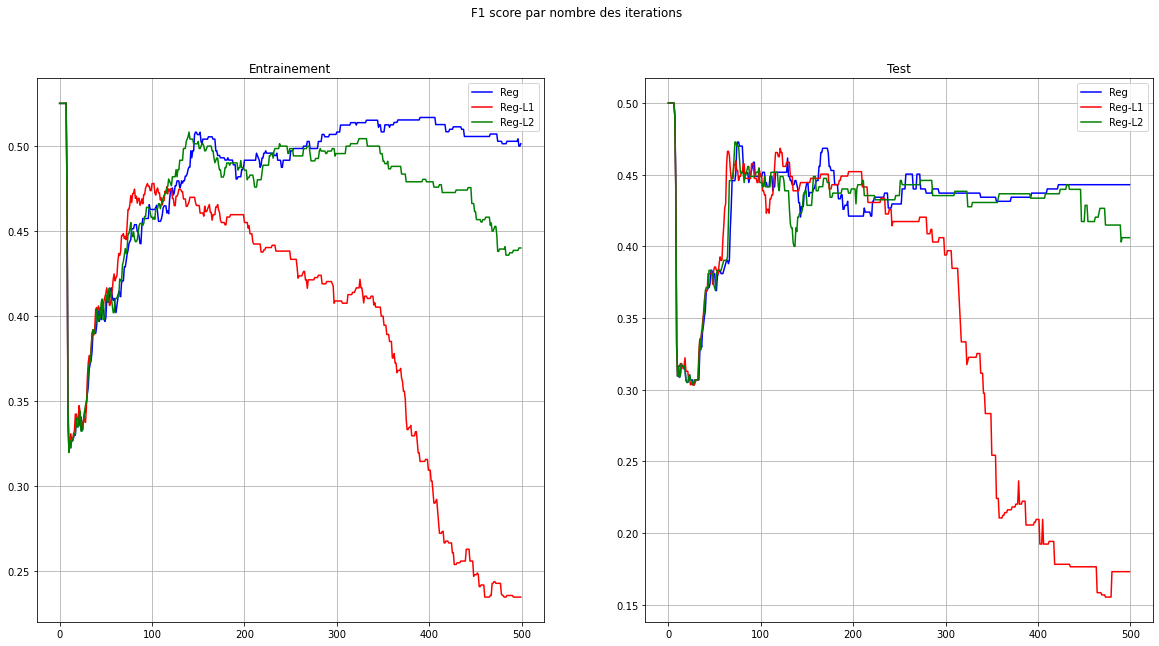

In [13]:
import warnings
from sklearn.exceptions   import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics      import f1_score
warnings.filterwarnings("ignore", category=ConvergenceWarning)

MAX_IT     = 500
CC         = 0.002
COEF_      = np.array([[1.] * X_train.shape[1]])
INTERCEPT_ = np.array([1.])

reglog = LogisticRegression(penalty='none', solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog.coef_      = COEF_.copy()
reglog.intercept_ = INTERCEPT_.copy()

reglog_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l1.coef_      = COEF_.copy()
reglog_l1.intercept_ = INTERCEPT_.copy()

reglog_l2 = LogisticRegression(penalty='l2', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l2.coef_      = COEF_.copy()
reglog_l2.intercept_ = INTERCEPT_.copy()

coefs         = []
coefs0        = []
f1train       = []
f1test        = []

coefs_ridge   = []
coefs0_ridge  = []
f1train_ridge = []
f1test_ridge  = []

coefs_lasso   = []
coefs0_lasso  = []
f1train_lasso = []
f1test_lasso  = []

for it in range(MAX_IT):
    reglog.fit(X_train, Y_train)
    coefs.append(reglog.coef_.flatten().tolist())
    coefs0.append(reglog.intercept_[0])
    f1train.append(f1_score(Y_train, reglog.predict(X_train)))
    f1test.append(f1_score(Y_test, reglog.predict(X_test)))
    
    reglog_l1.fit(X_train, Y_train)
    coefs_lasso.append(reglog_l1.coef_.flatten().tolist())
    coefs0_lasso.append(reglog_l1.intercept_[0])
    f1train_lasso.append(f1_score(Y_train, reglog_l1.predict(X_train)))
    f1test_lasso.append(f1_score(Y_test, reglog_l1.predict(X_test)))
    
    reglog_l2.fit(X_train, Y_train)
    coefs_ridge.append(reglog_l2.coef_.flatten().tolist())
    coefs0_ridge.append(reglog_l2.intercept_[0])
    f1train_ridge.append(f1_score(Y_train, reglog_l2.predict(X_train)))
    f1test_ridge.append(f1_score(Y_test, reglog_l2.predict(X_test)))


coefs       = np.array(coefs)
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_lasso, color="red", label="Reg-L1")
ax1.plot(range(MAX_IT), f1train_ridge, color="green", label="Reg-L2")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_lasso, color="red", label="Reg-L1")
ax2.plot(range(MAX_IT), f1test_ridge, color="green", label="Reg-L2")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

**TODO: Analyser les résultats**

- Que remarquez-vous ?
- Analyser les cas de convergence (qui converge plus rappidement, avec quel prix (quel est le gain ou la perte)) en précisant dans ce cas l'intérêt de la régularisation. 
- Pourquoi les modèles avec régularisation perdent-ils de performance avec plus d'térations ?

**Réponse**

- Nous remarquons que l'algorihtme de régression avec regularisation L1 converge le plus rapidement, ensuite celui avec régularisation L2 puis regression sans régularisation. 
- Dans le cas de convergence, càd, régularisation L1, les calculs sont plus complexes mais l'interet est atteint : réduction du sur-apprentissage ( on remarque que l'algorithme performe bien dans la généralisation ).
- Comme nous utilisons la régularisation (en ajoutant une valeur de pénalité), nous devrions atteindre la solution optimale après quelques itérations, de sorte que les valeurs des fonctions de perte seront proches de 0, mais en utilisant de plus en plus d'itérations, nous continuerons à ajouter la valeur de pénalité, ce qui augmentera la perte totale de la régularisation et nous nous éloignerons de l'optimum. 
<br/> <br/>
$$ Regularization = Loss Function + Penalty $$ 


#### II.1.2. Convergence des paramètres par itérations

Ici, nous avons afficher les valeurs des paramètres thétas pour chaque itération. 


In [14]:
%matplotlib qt
labels = list(diabetes.columns)
labels.pop()
#labels = ["Theta0"] + labels
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle("Convergence des thetas")
fig.set_figwidth(10)
fig.set_figheight(20)
for i in range(len(labels)): 
    ax1.plot(range(MAX_IT), coefs[:, i], label=labels[i])
    ax3.plot(range(MAX_IT), coefs_lasso[:, i], label=labels[i])
    ax2.plot(range(MAX_IT), coefs_ridge[:, i], label=labels[i])
ax1.plot(range(MAX_IT), coefs0, label="Theta0")
ax2.plot(range(MAX_IT), coefs0_ridge, label="Theta0")
ax3.plot(range(MAX_IT), coefs0_lasso, label="Theta0")
ax1.legend()
ax1.set_title("Regression")
ax1.grid()
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()
ax2.legend()
ax2.set_title("Regression+L2")
ax2.grid()

plt.show()

**TODO: Analyser les résultats**

- Que remarquez-vous ?
- Analyser la convergence des valeurs des paramètres entre les trois modèles (pourquoi dans les deux modèles avec régularisation, les valeurs se rapprochent plus de 0, pourquoi il y a des paramètres qui convergent plus rappidement que d'autres)
- Pouvons-nous déduire les attributs jugés importants par le modèle ? Si oui, lesquels ? Si non, pourquoi ?
- Est-ce que la régularisation peut être utilisée comme sélection d'attribut ? Préciser (avec argumentation)

**Réponse**

- La convergence des Thetas est plus rapide avec régularisation que sans.
- Les modèles avec régularisation forcent les paramètres à tendre vers zéro, car ils sont inclus dans la fonction cout qui sera minimisée pendant l'entrainement, la régularisation présente donc une contrainte sur ces paramètres. Étant donné que la régression ridge présente une contrainte sphérique, l'intersection avec les thétas optimaux ne se produira généralement pas sur un axe, et les coeﬃcient estimés de la régression ridge seront donc exclusivement non nuls. Cependant, la contrainte lasso a des coins à chacun des axes (contrainte cubique), et donc l'ellipse coupera souvent la région de la contrainte sur un axe. Lorsque cela se produit, l'un des coeﬃcients sera égal à zéro. Dans les dimensions supérieures (où les paramètres sont bien plus que 2), plusieurs des estimations coeﬃcient peuvent être égales à zéro simultanément. Par contree, les paramètres du modèle sans régularisation n'ont aucune contrainte qui les forcent à tendre vers zéro, et la convergence est beaucoup moins rapide.
- Oui, les attributs dont les coefficients ne tendent pas vers zéros à 100/150 itérations (la convergece des modèles)  sont jugés importants par le modèle et doivent participer à la costruction du modèle, ces attributs sont : Pregnancies, BloodPressure, BMI, DiabetesPedigreeFunction et Age.	
- Oui, car elle force les paramètres thétas à avoir des petites valeurs voire nulles après convergence tout en minimisant l'erreur ce qui force  le modèle à ne considérer que les attributs qui ont des coefficients non nuls et ceux sont les attreibuts importants.

### II.2. Sélection d'attributs

Ici, on va utiliser le même dataset précédent sur plusieurs types de sélection d'attributs.

#### II.2.1. Sélection d'attributs par filtrage (Choix ANOVA)

Nous avons extrait les F values ANOVA pour les différents attributs. 


In [15]:
from sklearn.feature_selection import f_classif
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color="green")
plt.xlabel("Les attributs")
plt.ylabel("Valeur F de ANOVA")
plt.title("Comparison entre les attributs de diabetes2 en terme de ANOVA")

plt.xticks(x_pos, labels_diabetes)

plt.show()


**TODO: Analyser les résultats** 

- Quels sont les attributs les plus importants d'après F values ?
- Pourquoi un attribut est considéré comme important dans ANOVA (aspect mathématique et logique : les valeurs de l'attribut et de la prédiction Y) ?
- Pourquoi nous avons utilisé ANOVA et pas Pearson ?

**Réponse**

- Les attributs les plus importants sont ceux qui ont un ratio ou F-value relativement grand, Donc  d'aprés le graphe des F-values on tire les attributs : Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction et Age.
- Un attribut est considéré important dans ANOVA si les valeurs de la meme classe de sortie ont moins de variance (variance intra-classe) et les valeurs des classes ont plus de variance avec le reste (variance inter-classes), càd, les valeurs de cet attribut ont une influence sur la sortie.
- Nous avons utilisé l'anova au lieu du pearson parce que nous sommes face à un problème de classification et non de régression (sortie nominale).

#### II.2.2. Sélection d'attributs par filtrage (Convergence et performance)

Ici, on va utiliser ANOVA pour pré-sélectionner les caractéristiques qui donnent 50% de variance. On veut comparer la convergence du modèle normal contre celui avec pré-sélection ANOVA.


In [16]:
from sklearn.feature_selection import SelectPercentile

selecteur = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selecteur.fit_transform(X_train, Y_train)
X_test_new = selecteur.transform(X_test)

reglog_anova = LogisticRegression(penalty='none', solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog_anova.coef_      = np.array([[1.] * X_train_new.shape[1]])
reglog_anova.intercept_ = INTERCEPT_

coefs_anova   = []
coefs0_anova  = []
f1train_anova = []
f1test_anova  = []

for it in range(MAX_IT):
    reglog_anova.fit(X_train_new, Y_train)
    coefs_anova.append(reglog_anova.coef_.flatten().tolist())
    coefs0_anova.append(reglog_anova.intercept_[0])
    f1train_anova.append(f1_score(Y_train, reglog_anova.predict(X_train_new)))
    f1test_anova.append(f1_score(Y_test, reglog_anova.predict(X_test_new)))

coefs_anova = np.array(coefs_anova)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_anova, color="red", label="Reg-ANOVA")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_anova, color="red", label="Reg-ANOVA")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

In [19]:
labels_new = selecteur.transform(np.array(diabetes.columns[:-1]).reshape(1, len(diabetes.columns)-1)).flatten()

for i in range(len(labels_new)): 
    plt.plot(range(MAX_IT), coefs_anova[:, i], label=labels_new[i])
plt.plot(range(MAX_IT), coefs0_anova, label="Theta0")
plt.legend()
plt.title("Regression+ANOVA")
plt.grid()
plt.show()

**TODO: Analyser les résultats** 

- Pourquoi la performance de la régression sans filtrage est meilleure dans l'entrainement et pas dans le test; et l'inverse pour la régression avec filtrage ? (P.S. nous ne parlons pas ici du sur-apprentissage; mais des attributs : nombre et qualité)
- Est-ce que le filtrage PEUT prévenir le sur-apprentissage ? Si oui, comment ? Si non, pourquoi ?

**Réponse**

- La régression sans filtrage donne de meilleures performances dans l'entrainement parce qu'il utilise toutes les caractéristiques, peu importe s'il y a de la redondance ou des caractéristiques sans signification, il est donc plus adapté pour l'ensemble d'entrainement, ce qui est confirmé par la mauvaise performance sur l'ensemble de test, mais en utilisant des filtres, nous éliminons la redondance et le bruit en gardant seulement les caractéristiques les plus représentatives, ce qui donne un peu moins de performance sur l'ensemble d'entrainement mais une meilleure généralisation pour l'ensemble de test.
- Oui,  le filtrage est un processus qui élimine les caractéristiques non pertinentes et redondantes de l'ensemble des données. et moins de données redondantes signifie moins de possibilités de prendre des décisions basées sur le bruit donc moins de possibilités de sur-apprentissage.

#### II.2.3. Comparaison entre les différentes approches de sélections d'attributs

Ici, nous voulons comparer des modèles appartenant à des différentes approches de sélection d'attributs : 
- **ANOVA** : c'est un modèle qui utilise la sélection d'attributs par filtrage. Ici, nous prenons les attributs qui participent à 50% de la variance (4 attributs dans notre cas)
- **L1** : c'est un modèle qui utilise la sélection d'attributs intégrée (embdded)
- **FFS (Forward Features Selection)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester un seul attribut et ajouter d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 
- **BFE (Backward Features Elimination)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester tous les attributs et éliminer d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 

Nous voulons tester les modèles par rapport à celui sans sélection d'attributs en se basant sur les critères suivants :
- **F1 entrainement** : ici on veut répondre à la question "combien un modèle peut-il converger vers sa solution ?"
- **F1 test** : ici on veut répondre à la question "combien un modèle peut-il généraliser ?"
- **Nombre des itérations** : ici on veut répondre à la question "combien faut-il d'itérations pour qu'un modèle converge ?"
- **Temps pré-entrainement** : ici on veut répondre à la question "combien de temps faut-il pour préparer les attributs avant l'entrainement ?"
- **Temps entrainement** : ici on veut répondre à la question "combien de temps faut-il pour l'entrainement ?"

*P.S. L'exécution prend un peu de temps*


In [21]:
from sklearn.feature_selection import SequentialFeatureSelector
import timeit

CMAX_ITER     = 5000
creglog       = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
creglog_l1    = LogisticRegression(penalty='l1', solver="saga", max_iter=CMAX_ITER)
creglog_anova = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)

temps   = {}
temps_p = {}

temps_debut = timeit.default_timer()
creglog.fit(X_train, Y_train)
temps["reg"] = timeit.default_timer() - temps_debut


temps_debut = timeit.default_timer()
creglog_l1.fit(X_train, Y_train)
temps["l1"] = timeit.default_timer() - temps_debut

temps_debut = timeit.default_timer()
selecteur_anova = SelectPercentile(score_func=f_classif, percentile=50)
X_train_anova= selecteur.fit_transform(X_train, Y_train)
temps_p["anova"] = timeit.default_timer() - temps_debut
X_test_anova = selecteur.transform(X_test)
temps_debut = timeit.default_timer()
creglog_anova.fit(X_train_anova, Y_train)
temps["anova"] = timeit.default_timer() - temps_debut

creglog_ffs = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
temps_debut = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(creglog_ffs, n_features_to_select=4, direction="forward")
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
temps_p["ffs"] = timeit.default_timer() - temps_debut
X_test_ffs = selecteur_ffs.transform(X_test)
temps_debut = timeit.default_timer()
creglog_ffs.fit(X_train_ffs, Y_train)
temps["ffs"] = timeit.default_timer() - temps_debut

creglog_bfe = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
temps_debut = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(creglog_bfe, n_features_to_select=4, direction="backward")
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
temps_p["bfe"] = timeit.default_timer() - temps_debut
X_test_bfe = selecteur_bfe.transform(X_test)
temps_debut = timeit.default_timer()
creglog_bfe.fit(X_train_bfe, Y_train)
temps["bfe"] = timeit.default_timer() - temps_debut


pd.DataFrame({
    "Criteres" : ["F1 Entrainement", "F1 Test", "Nombre des itérations", "temps pré-entrainement", "temps entrainement"],
    "Reg" : [f1_score(Y_train, creglog.predict(X_train)), 
             f1_score(Y_test, creglog.predict(X_test)),
             creglog.n_iter_, 0, temps["reg"]],
    "Reg+L1" : [f1_score(Y_train, creglog_l1.predict(X_train)), 
                f1_score(Y_test, creglog_l1.predict(X_test)), 
                creglog_l1.n_iter_, 0, temps["l1"]],
    "ANOVA+Reg" : [f1_score(Y_train, creglog_anova.predict(X_train_anova)), 
                f1_score(Y_test, creglog_anova.predict(X_test_anova)), 
                creglog_anova.n_iter_, temps_p["anova"], temps["anova"]],
    "FFS" : [f1_score(Y_train, creglog_ffs.predict(X_train_ffs)), 
                f1_score(Y_test, creglog_ffs.predict(X_test_ffs)), 
                creglog_ffs.n_iter_, temps_p["ffs"], temps["ffs"]],
    "BFE" : [f1_score(Y_train, creglog_bfe.predict(X_train_bfe)), 
                f1_score(Y_test, creglog_bfe.predict(X_test_bfe)), 
                creglog_bfe.n_iter_, temps_p["bfe"], temps["bfe"]],
})

,Criteres,Reg,Reg+L1,ANOVA+Reg,FFS,BFE
0,F1 Entrainement,0.465574,0.465574,0.382353,0.567568,0.585526
1,F1 Test,0.380165,0.380165,0.37931,0.564516,0.539683
2,Nombre des itérations,[1406],[1404],[226],[5000],[5000]
3,temps pré-entrainement,0,0,0.001248,20.839019,35.648753
4,temps entrainement,0.185111,0.209533,0.017158,0.415392,0.404486


**TODO: Analyser les résultats** 

- Pourquoi la sélection d'attributs envelopante prend plus de temps d'entrainement pourtant elle utilise moins d'attributs ? (en se basant sur les résultats)
- Pourquoi la régression avec L1 prend plus de temps d'entrainement que la régression normale pourtant elle prend moins d'itérations ?
- Pourquoi la sélection d'attributs enveloppante donne des performances mieux que celle par filtrage pourtant cette dernière sélectionne les meilleurs attributs en terme de corrélation ? (dans notre cas, c'est le même nombre d'attributs = 4)
- Si vous avez un dataset avec plusieurs attributs et une quantité énorme d'échantillons, proposer une solution avec moins de temps de pré-entrainement+entrainement et plus de performance (par rapport la solution sans sélection d'attributs) en se basant sur les résultats de cette expérimentation.

**Réponse**

- La sélection d'attributs enveloppante (méthodes wrapper) nécessite un temps d'entrainement plus long, car elle prend chaque fois un sous-ensemble d'attributs, puis entraîne un modèle en les utilisant, et en fonction des interférences du modèle précédent, c'est-à-dire de l'utilité de ce sous-ensemble, elle décide d'ajouter (BFE) ou de supprimer (FFS) les attributs.
- la régression avec L1 prend plus de temps d'apprentissage que la régression normale car l'ajout de la régularisation nécessite plus de calculs (détermination du paramètre de régularisation + additions en plus).
- Les méthodes de filtrage mesurent la  pertinence  des caractéristiques par leur corrélation avec la variable dépendante, tandis que les méthodes wrapper mesurent l'utilité d'un sous-ensemble de caractéristiques en formant réellement un modèle sur celles-ci.
- Si on veut gagner plus dans le temps, on peut utiliser les filtres, puisque dans les méthodes de sélection d'attribut  basées sur des filtres (ex. ANOVA) , la sélection d'un sous-ensemble de caractéristiques est effectuée sur la base d'un critère d'évaluation spécifique (ex. gain d'information) sans tenir compte des algorithmes d'apprentissage, ce type de méthodes est approprié pour le traitement de données de grande taille.
-  Si on voulait gagner plus en performance, on utilise les méthodes intégrées : utiliser l'approche par filtre pour réduire une partie de la dimensionnalité, puis appliquer uniquement l'approche wrapper pour sélectionner le meilleur sous-ensemble de caractéristiques.